# Part 1: Developing an equivalent circuit model in Collimator (two methods)

## Physics-based battery models

Physics-based battery models are essential tools in understanding and predicting the performance of batteries under various operating conditions. The Single Particle Model (SPM) is one of the simplest forms, representing each electrode as a single spherical particle. This model captures the basic electrochemical processes and is particularly useful for its computational efficiency. However, it oversimplifies the complex internal structures of the electrodes. The Doyle-Fuller-Newman (DFN) model, on the other hand, offers a more comprehensive approach. It includes the detailed physics of charge and mass transport within the electrodes and the electrolyte, making it a more accurate but computationally intensive model. Lastly, Equivalent Circuit Models (ECMs) represent the battery using electrical circuit elements like resistors, capacitors, and voltage sources. ECMs are widely used for battery management systems due to their simplicity and ability to fit experimental data, but they lack the detailed physics captured by models like the DFN. Each of these models serves different purposes, ranging from detailed analysis to real-time battery management applications.

In this example, we show how to model ECMs in Collimator. For SPM and DFN models, we recommend the `pybamm` Python library.

### Equivalent Circuit Model (ECM)
The ECM considered is a Thevenin model with one RC branch. Its schematic is shown in the Figure below.

<img src="../media/thevenin_schematic.png" alt="Thevenin model with one RC branch" width=600px/>

<!--- ![Thevenin model with one RC branch](./figs/thevenin_schematic.png) --->

The variables and parameters of the model have the following interpretation

| Variable/Parameter | Interpretation |
|----------|----------|
| $Q$    | Total capacity of the battery (typically specified in ampere-hours) [Ah]    |
| $s$    | Battery state-of-charge (SoC) [-]   |
| $v_0$    | Open circuit voltage of the battery [V]     |
| $v_t$    | Terminal voltage of the battery  [V]   |
| $v_{C_1}$    | Voltage across the capacitor  [V]   |
| $i$      | Discharge current (current to the load) [A]     |
| $R_s$    | Internal resistance of the battery  [$\Omega$]   |
| $R_1$    | R1-C1 branch models slow diffusion processes in the battery [$\Omega$]   |
| $C_1$    | R1-C1 branch models slow diffusion processes in the battery [F]   |


State-of-charge (SoC) is a variable used to represent the current level of energy stored in a battery relative to its total capacity. Expressed as a percentage, SoC is an indicator of how much charge is remaining in the battery; an SoC of 100% ($s=1$) means the battery is fully charged, and an SoC of 0% ($s=0$) indicates it is completely discharged. The total capacity $Q$ of a battery, measured typically in ampere-hours (Ah), is the maximum amount of charge it can hold when fully charged. The SoC can be calculated by dividing the current charge $q$ (the amount of charge present at any given time) by the total capacity $Q$. 

Note that $v_0$, $R_s$, $R_1$, and $C_1$ typically depend on the state-of-charge ($s$), cell temperature ($T$), and C-rate (rate of battery discharge relative to nominal capacity of the battery). However, in this demo we ignore dependencies on $T$ and C-rate, and only consider dependencies of these parameters on $s$.

### ECM equations

Based on the above Figure, the system of ordinary differential equations governing battery dynamics are:

\begin{align}
\dot{s} &= -\frac{i}{3600 Q} \\[5pt]
\dot{v}_{C_1} \ &= \frac{1}{C_1} \left( i - \frac{v_{C_1}}{R_1} \right),
\end{align}

where the factor $3600$ in the denominator converts $Q$ from Ampere-hours to Ampere-seconds. The terminal voltage $v_t$ is given by an algebraic relation:

$$ v_t = v_0 - i R_s - v_{C_1}. $$

## Model implementation in Collimator as a LeafSystem (Method-1)

We would like to implement battery as a block that takes current $i$ as an input and generates two outputs $s$ and $v_t$. The easiest way to implement the above model in Collimator is as an independent LeafSystem. The dependence of $v_0$, $R_s$, $R_1$, and $C_1$ on $s$ implies that these parameters are curves. We specify these curves through a set of discrete points, and then linearly interpolate between these points to represent the curves.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp

import collimator
from collimator.library import Constant, Pulse
from collimator.framework import LeafSystem

from collimator.simulation import SimulatorOptions

from collimator import logging

logging.set_log_level(logging.ERROR)


class Battery(LeafSystem):
    def __init__(
        self,
        soc_0=1.0,  # initial value of SoC
        vc1_0=0.0,  # initial value of voltage across capacitor
        Q=100.0,  # total capacity of the battery
        soc_points=jnp.linspace(
            0, 1, 11
        ),  # discrete SoC points at which v_0, Rs, R1, and C1 are specified
        v0_points=5.0 * jnp.ones(11),  # discrete values of v0 at soc_points
        Rs_points=15e-03 * jnp.ones(11),  # discrete values of Rs at soc_points
        R1_points=25e-03 * jnp.ones(11),  # discrete values of R1 at soc_points
        C1_points=3e03 * jnp.ones(11),  # discrete values of C1 at soc_points
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.soc_0 = soc_0
        self.vc1_0 = vc1_0
        self.Q = Q

        self.soc_points = soc_points
        self.declare_dynamic_parameter(
            "v0_points", v0_points
        )  # declare as parameters so that these can be changed in the context
        self.declare_dynamic_parameter("Rs_points", Rs_points)
        self.declare_dynamic_parameter("R1_points", R1_points)
        self.declare_dynamic_parameter("C1_points", C1_points)

        self.declare_input_port()  # input port for the discharge current

        self.declare_continuous_state(
            shape=(2,),  # Two continuous states: soc and vc1
            ode=self.ode,
            default_value=jnp.array([self.soc_0, self.vc1_0]),
        )

        self.declare_output_port(
            self._eval_output_soc, default_value=0.5
        )  # output port for soc
        self.declare_output_port(
            self._eval_output_vt, default_value=2.5
        )  # output port for terminal voltage vt

    def _eval_output_soc(
        self, time, state, current, **params
    ):  # output port evaluation for soc
        x = state.continuous_state
        soc = x[0]
        return soc

    def _eval_output_vt(
        self, time, state, current, **params
    ):  # output port evaluation for vt
        x = state.continuous_state
        soc = x[0]
        vc1 = x[1]

        v0 = jnp.interp(soc, self.soc_points, params["v0_points"])
        Rs = jnp.interp(soc, self.soc_points, params["Rs_points"])

        vt = v0 - current * Rs - vc1  # compute terminal voltage
        return vt

    def ode(self, time, state, current, **params):  # ODE system in soc and vt
        x = state.continuous_state
        soc = x[0]
        vc1 = x[1]

        R1 = jnp.interp(soc, self.soc_points, params["R1_points"])
        C1 = jnp.interp(soc, self.soc_points, params["C1_points"])
        dot_soc = -current / 3600.0 / self.Q  # compute d/dt (soc)
        dot_vc1 = current / C1 - vc1 / R1 / C1  # compute d/dt (vc1)
        return jnp.array([dot_soc, dot_vc1])

The above system can now be simulated, provided a current input is provided to the LeafSystem. Let's apply a constant discharge current and simulate the system.

Initialized callback battery:u_0 with prereqs []
Initialized callback battery:battery_ode with prereqs [1, 2, 8]
Initialized callback battery:y_0 with prereqs [8]
Initialized callback battery:y_1 with prereqs [8]


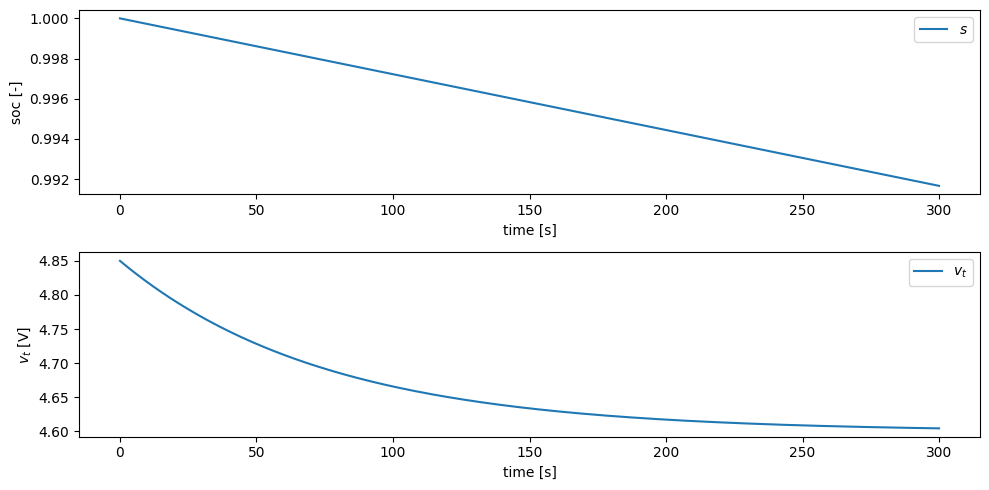

In [3]:
builder = collimator.DiagramBuilder()
battery = builder.add(
    Battery(name="battery")
)  # Create a battery with the default parameters
battery.input_ports[0].fix_value(
    10.0
)  # Specify the constant discharge current (C10 : 100/10 = 5A)

diagram = builder.build()
context = diagram.create_context()  # Create default context

# Specify which signals to record in the simulation output
recorded_signals = {"soc": battery.output_ports[0], "vt": battery.output_ports[1]}

t_span = (0.0, 5 * 60)  # span over which to simulate the system: 5 minutes

# simulate the combination of diagram and context over t_span
options = SimulatorOptions(max_minor_step_size=1.0)
sol = collimator.simulate(
    diagram, context, t_span, options=options, recorded_signals=recorded_signals
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
ax1.plot(sol.time, sol.outputs["soc"], label=r"$s$")
ax2.plot(sol.time, sol.outputs["vt"], label=r"$v_t$")
ax1.set_xlabel("time [s]")
ax1.set_ylabel("soc [-]")
ax1.set_xlabel("time [s]")
ax2.set_xlabel("time [s]")
ax2.set_ylabel("$v_t$ [V]")
ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()

As expected, the decrease in $s$ is linear. Note that our dependence of $v_0$, $R_s$, $R_1$, and $C_1$ on $s$ is flat (default battery parameters) and battery capacity is 100 Ah.

We can simulate a pulse discharge current by either creating another LeafSystem that produces a pulse or we can use the built-in `Pulse` block available to us from the Collimator library.

Initialized callback battery:u_0 with prereqs []
Initialized callback battery:battery_ode with prereqs [1, 2, 8]
Initialized callback battery:y_0 with prereqs [8]
Initialized callback battery:y_1 with prereqs [8]
Initialized callback discharge_current:out_0 with prereqs [1]


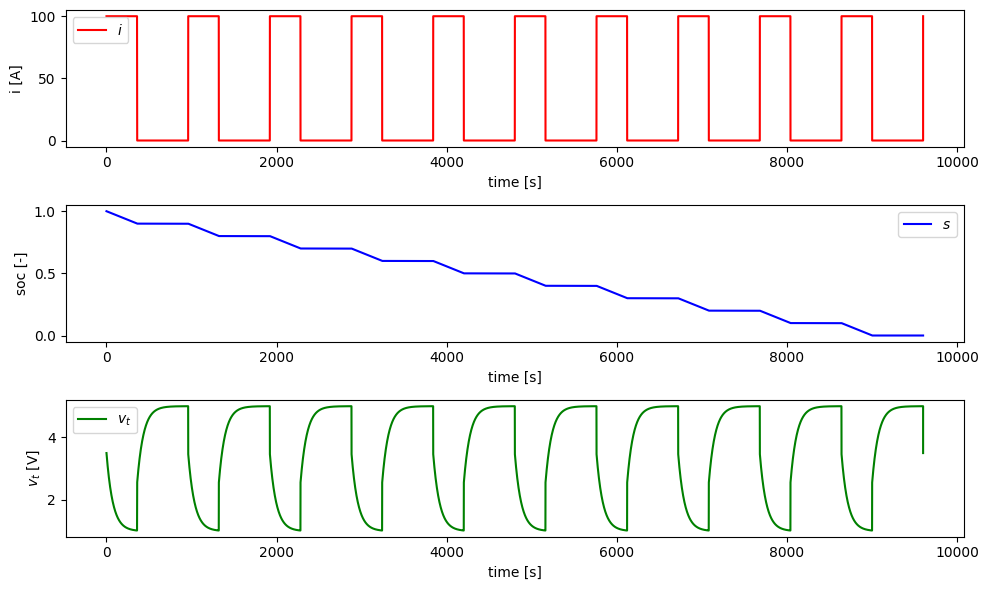

In [4]:
builder = collimator.DiagramBuilder()
battery = builder.add(
    Battery(name="battery")
)  # Create a battery with the default parameters

discharge_current = builder.add(
    Pulse(100.0, 6 / 16.0, 16 * 60.0, name="discharge_current")
)  # Add a pulse block

# We have two blocks/LeafSystems: discharge_current and battery. We need to connect the output
# of the discharge_current to the input of the battery.
builder.connect(discharge_current.output_ports[0], battery.input_ports[0])

diagram = builder.build()
context = diagram.create_context()  # Create default context

# Specify which signals to record in the simulation output
recorded_signals = {
    "discharge_current": discharge_current.output_ports[0],
    "soc": battery.output_ports[0],
    "vt": battery.output_ports[1],
}

t_span = (0.0, 9600.0)  # span over which to simulate the system

# simulate the combination of diagram and context over t_span
sol = collimator.simulate(
    diagram, context, t_span, options=options, recorded_signals=recorded_signals
)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))
ax1.plot(sol.time, sol.outputs["discharge_current"], "-r", label=r"$i$")
ax2.plot(sol.time, sol.outputs["soc"], "-b", label=r"$s$")
ax3.plot(sol.time, sol.outputs["vt"], "-g", label=r"$v_t$")
ax1.set_ylabel("i [A]")
ax2.set_ylabel("soc [-]")
ax3.set_ylabel("$v_t$ [V]")
for ax in (ax1, ax2, ax3):
    ax.set_xlabel("time [s]")
    ax.legend(loc="best")
fig.tight_layout()
plt.show()

The battery block/LeafSystem with discharge current $i$ input and two outputs of SoC $s$ and terminal voltage $v_t$ can now be used with any composition of other blocks/LeafSystems.

## Model implementation in Collimator through primitives (Method-2)

Another way to implement the same battery model is through primitive blocks available in the Collimator library. A schematic of this approach is shown below.

<img src="../media/battery_schematic_primitives.png" alt="Battery through primitive blocks" width=1200px/>

For each of the blocks in the above Figure, there is a primitive block available in the Collimator library. To create the diagram, we add the primitive blocks and connect them as shown in the Figure above. This system can be built as follows:

In [5]:
from collimator.library import *


def make_battery_from_primitives(
    soc_0=1.0,  # initial value of SoC
    vc1_0=0.0,  # Iniital value of voltage across capacitor
    Q=100.0,  # Total capacity of the battery
    soc_points=jnp.linspace(
        0, 1, 11
    ),  # discrete SoC points at which v_0, Rs, R1, and C1 are specified
    v0_points=5.0 * jnp.ones(11),  # discrete values of v0 at soc_points
    Rs_points=15e-03 * jnp.ones(11),  # discrete values of Rs at soc_points
    R1_points=25e-03 * jnp.ones(11),  # discrete values of R1 at soc_points
    C1_points=3e03 * jnp.ones(11),  # discrete values of C1 at soc_points
    name="battery",
):
    builder = collimator.DiagramBuilder()

    # Creat and IO port for current input
    current = builder.add(IOPort(name="discharge_current"))

    # Keep track of soc through a current integrator (solve ODE for soc)
    dot_soc = builder.add(Gain(-1.0 / 3600.0 / Q))
    soc = builder.add(Integrator(soc_0, name="soc"))
    builder.connect(current.output_ports[0], dot_soc.input_ports[0])
    builder.connect(dot_soc.output_ports[0], soc.input_ports[0])

    # Lookup blocks to capture the dependency of v0, Rs, R1, and C1 on soc
    v0 = builder.add(LookupTable1d(soc_points, v0_points, "linear", name="v0"))
    Rs = builder.add(LookupTable1d(soc_points, Rs_points, "linear", name="Rs"))
    R1 = builder.add(LookupTable1d(soc_points, R1_points, "linear", name="R1"))
    C1 = builder.add(LookupTable1d(soc_points, C1_points, "linear", name="C1"))

    # Connect the soc to lookup blocks
    builder.connect(soc.output_ports[0], v0.input_ports[0])
    builder.connect(soc.output_ports[0], Rs.input_ports[0])
    builder.connect(soc.output_ports[0], R1.input_ports[0])
    builder.connect(soc.output_ports[0], C1.input_ports[0])

    # ODE for vc1
    i_over_C1 = builder.add(Product(2, operators="*/", name="i_over_C1"))
    vc1_over_tau1 = builder.add(Product(3, operators="*//", name="vc1_over_tau1"))
    dot_vc1 = builder.add(Adder(2, operators="+-", name="dot_vc1"))
    vc1 = builder.add(Integrator(vc1_0, name="vc1"))

    builder.connect(current.output_ports[0], i_over_C1.input_ports[0])
    builder.connect(C1.output_ports[0], i_over_C1.input_ports[1])

    builder.connect(vc1.output_ports[0], vc1_over_tau1.input_ports[0])  # feedback
    builder.connect(R1.output_ports[0], vc1_over_tau1.input_ports[1])
    builder.connect(C1.output_ports[0], vc1_over_tau1.input_ports[2])

    builder.connect(i_over_C1.output_ports[0], dot_vc1.input_ports[0])
    builder.connect(vc1_over_tau1.output_ports[0], dot_vc1.input_ports[1])

    builder.connect(dot_vc1.output_ports[0], vc1.input_ports[0])

    # Algebraic equation to get v (terminal voltage)
    i_Rs = builder.add(Product(2, operators="**", name="i_Rs"))
    vt = builder.add(Adder(3, operators="+--", name="vt"))

    builder.connect(current.output_ports[0], i_Rs.input_ports[0])
    builder.connect(Rs.output_ports[0], i_Rs.input_ports[1])

    builder.connect(v0.output_ports[0], vt.input_ports[0])
    builder.connect(i_Rs.output_ports[0], vt.input_ports[1])
    builder.connect(vc1.output_ports[0], vt.input_ports[2])

    # Diagram-level inport/outport
    builder.export_input(current.input_ports[0])  # current
    builder.export_output(soc.output_ports[0])  # soc
    builder.export_output(vt.output_ports[0])  # terminal voltage

    return builder.build(name=name)

The above can be used in a similar manner to the previous custom LeafSystem model of Method-1.

Initialized callback discharge_current:u_0 with prereqs []
Initialized callback discharge_current:y_0 with prereqs [21]
Initialized callback Gain_7_:u_0 with prereqs []
Initialized callback Gain_7_:y_0 with prereqs [23]
Initialized callback soc:in_0 with prereqs []
Initialized callback soc:soc_ode with prereqs [25]
Initialized callback soc:out_0 with prereqs [2]
Initialized callback v0:u_0 with prereqs []
Initialized callback v0:y_0 with prereqs [28]
Initialized callback Rs:u_0 with prereqs []
Initialized callback Rs:y_0 with prereqs [30]
Initialized callback R1:u_0 with prereqs []
Initialized callback R1:y_0 with prereqs [32]
Initialized callback C1:u_0 with prereqs []
Initialized callback C1:y_0 with prereqs [34]
Initialized callback i_over_C1:u_0 with prereqs []
Initialized callback i_over_C1:u_1 with prereqs []
Initialized callback i_over_C1:y_0 with prereqs [36, 37]
Initialized callback vc1_over_tau1:u_0 with prereqs []
Initialized callback vc1_over_tau1:u_1 with prereqs []
Initia

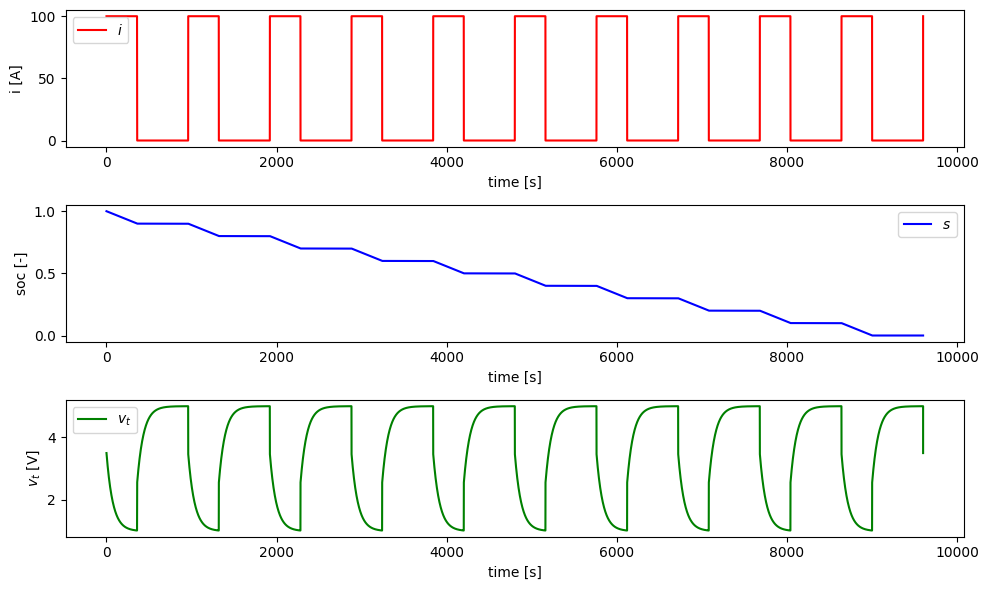

In [6]:
builder = collimator.DiagramBuilder()
battery = make_battery_from_primitives(
    name="battery"
)  # Create a battery with the default parameters

builder.add(battery)  # add the battery to the system

discharge_current = builder.add(
    Pulse(100.0, 6 / 16.0, 16 * 60.0, name="discharge_current")
)  # Add a pulse block

# We have two blocks/LeafSystems: discharge_current and battery. We need to connect the output
# of the discharge_current to the input of the battery.
builder.connect(discharge_current.output_ports[0], battery.input_ports[0])

diagram = builder.build()
context = diagram.create_context()  # Create default context

# Specify which signals to record in the simulation output
recorded_signals = {
    "discharge_current": discharge_current.output_ports[0],
    "soc": battery.output_ports[0],
    "vt": battery.output_ports[1],
}

t_span = (0.0, 9600.0)  # span over which to simulate the system

# simulate the combination of diagram and context over t_span
sol = collimator.simulate(
    diagram, context, t_span, options=options, recorded_signals=recorded_signals
)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))
ax1.plot(sol.time, sol.outputs["discharge_current"], "-r", label=r"$i$")
ax2.plot(sol.time, sol.outputs["soc"], "-b", label=r"$s$")
ax3.plot(sol.time, sol.outputs["vt"], "-g", label=r"$v_t$")
ax1.set_ylabel("i [A]")
ax2.set_ylabel("soc [-]")
ax3.set_ylabel("$v_t$ [V]")
for ax in (ax1, ax2, ax3):
    ax.set_xlabel("time [s]")
    ax.legend(loc="best")
fig.tight_layout()
plt.show()

In the following parts, we will only work with Method-1 for demonstration.